In [1]:
# Compare result of lora and freeze
%load_ext autoreload
%autoreload 2

from matplotlib import pyplot as plt
from MlflowHelper import *
from DensePoisson import *
from PlotHelper import *
import mlflow

In [48]:
h = MlflowHelper()
runs = mlflow.search_runs(experiment_names=["lora-fixstep"])

In [49]:
res_list = []
data_list = []
total_list = []
step_list = []

# For each run, get the metrics history
for run in runs.iterrows():
    run_id = run[1]['run_id']
    # Get history
    history,_ = h.get_metric_history(run_id)
    
    # Append the 'res' and 'data' histories to the lists
    res_list.append(history['res'])
    data_list.append(history['data'])
    total_list.append(history['total'])
    step_list.append(history['steps'])

# Add the 'res' and 'data' columns to the DataFrame
runs['res'] = res_list
runs['data'] = data_list
runs['total'] = total_list
runs['steps'] = step_list

res 0.0003819137637037784
data 2.0725951510591756e-10
total 0.0003819139674305916
D 1.0
res 0.0001637725654290989
data 1.5701770439413565e-10
total 0.00016377272550016642
D 1.0
res 0.0023891336750239134
data 4.473204029409317e-09
total 0.002389138098806143
D 1.0
res 19.95336151123047
data 0.006929923314601183
total 19.960290908813477
D 1.0
res 0.000137926937895827
data 1.864960789965675e-11
total 0.00013792695244774222
D 1.0
res 0.0004402617341838777
data 8.32160722552544e-08
total 0.0004403449420351535
D 1.0
res 579.6336059570312
data 0.6211326122283936
total 580.2547607421875
D 1.0
res 5.81709282414522e-05
data 2.092329198788434e-09
total 5.817302007926628e-05
D 1.0
res 2.313808181497734e-05
data 2.4385294131179513e-12
total 2.3138083633966744e-05
D 1.0
res 0.00012531393440440297
data 9.414248269834502e-10
total 0.00012531488027889282
D 1.0
res 180.2186737060547
data 0.20350320637226105
total 180.42218017578125
D 1.0
res 0.000420451833633706
data 1.48559029661266e-11
total 0.00042045

In [50]:

def create_legend_name(row):
    if row['params.transfer_method'] == 'lora' and 'params.rank' in row:
        return f'LoRA rank {row["params.rank"]}'
    elif row['params.transfer_method'] == 'freeze' and 'params.nlayer_train' in row:
        return f'FT top {row["params.nlayer_train"]}'
    else:
        return 'Unknown'

def compute_parameters(row):
    if row['params.transfer_method'] == 'lora' and 'params.rank' in row:
        return int(row['params.rank']) * 64 * 3
    elif row['params.transfer_method'] == 'freeze' and 'params.nlayer_train' in row:
        return 64 + ( int(row['params.nlayer_train']) - 1) * (64*64 + 64)
    else:
        return None

runs['parameters'] = runs.apply(compute_parameters, axis=1)

runs['legend_name'] = runs.apply(create_legend_name, axis=1)

In [51]:
runs.legend_name
runs.parameters

0      8384
1       384
2       576
3      4224
4       768
5       192
6        64
7     12544
8     12544
9       768
10     4224
11     8384
12       64
13      384
14      192
15      576
16      768
17      768
Name: parameters, dtype: int64

In [52]:
runs['tags.mlflow.runName']

0     freeze_l3_noff
1      lora_rk2_noff
2      lora_rk3_noff
3     freeze_l2_noff
4      lora_rk4_noff
5      lora_rk1_noff
6     freeze_l1_noff
7     freeze_l4_noff
8       freeze_l4_ff
9        lora_rk4_ff
10      freeze_l2_ff
11      freeze_l3_ff
12      freeze_l1_ff
13       lora_rk2_ff
14       lora_rk1_ff
15       lora_rk3_ff
16           p1D1_ff
17         p1D1_noff
Name: tags.mlflow.runName, dtype: object

/tmp/ipykernel_3099152/2765648625.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  runs_to_plot.sort_values('tags.mlflow.runName', inplace=True)


(0.0, 10000.0)

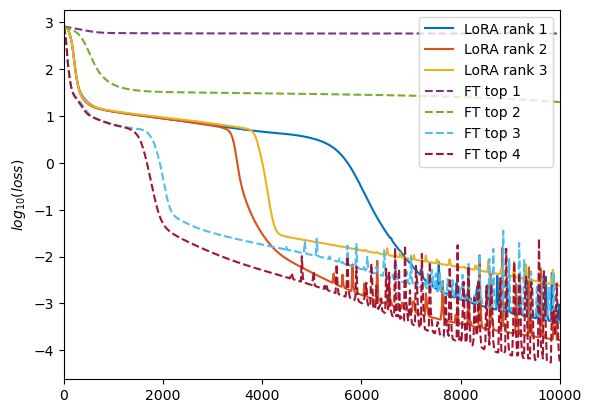

In [53]:
import pandas as pd
import numpy as np


runs_plot = ['lora_rk1_noff', 'lora_rk2_noff','lora_rk3_noff', 'freeze_l1_noff', 'freeze_l2_noff', 'freeze_l3_noff','freeze_l4_noff']
window_size = 1
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#0072BD', '#D95319', '#EDB120', '#7E2F8E', '#77AC30', '#4DBEEE', '#A2142F'])

# Filter the DataFrame to include only the runs you want to plot
runs_copy = runs.copy()

runs_copy['tags.mlflow.runName'] = pd.Categorical(runs_copy['tags.mlflow.runName'], categories=runs_plot, ordered=True)
runs_to_plot = runs_copy[runs_copy['tags.mlflow.runName'].isin(runs_plot)]
runs_to_plot.sort_values('tags.mlflow.runName', inplace=True)

plt.close()
# Create a new figure
plt.figure()

# For each run to plot, plot the 'data' sequence
for _, run in runs_to_plot.iterrows():
    # Get the 'data' sequence and the legend name
    data = pd.Series(run['total'])

    # data = np.log1p(data)
    data = data.rolling(window_size).mean()
    data = np.log10(data)

    legend_name = f'{run["legend_name"]}'

    # Determine the line style based on the transfer method
    if run['params.transfer_method'] == 'lora':
        line_style = '-'
    else:
        line_style = '--'

    # Plot the 'data' sequence
    x = np.arange(len(data))*20
    plt.plot(x, data, line_style, label=legend_name)

# Set the y-axis to log scale
# plt.yscale('log')

# Show the legend
plt.legend(loc='upper right')
plt.ylabel('$log_{10}(loss)$')

# ticks = np.log1p([1e-0, 1e-1, 1e-2, 1e-3,])
# plt.yticks(ticks, [f'{tick:.0e}' for tick in np.expm1(ticks)])

# set x lim
plt.xlim(0, 10000)

In [58]:

base = 'lora-fixstep:p1D1_noff'
base_model, _ = load_model(name_str = base)

transfer = 'lora-fixstep:freeze_l4_noff'
target_model, _ = load_model(name_str = transfer)

layer_name = 'hidden_layers.1.weight'

s1,s2,s_diff = output_svd(base_model, target_model, layer_name)


net loaded from /home/ziruz16/adjointpinn/mlruns/690849876767752235/c724c616dacf45d5aafe86f56207404e/artifacts/net.pth
net loaded from /home/ziruz16/adjointpinn/mlruns/690849876767752235/51c7e5ad98304b1e8fbc5a98f7d6a70b/artifacts/net.pth


(1e-08, 100)

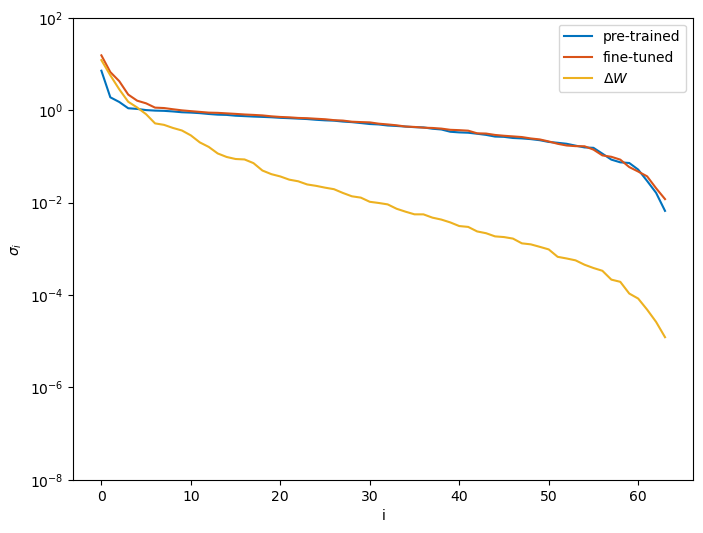

In [59]:
fig, ax = plot_svd(s1, s2, s_diff, 'pre-trained', 'fine-tuned', '$\Delta W$')
ax.set_xlabel('i')
ax.set_ylabel('$\sigma_i$')
ax.legend()
ax.set_ylim(1e-8, 100)